In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Wound Detection')
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Wound Detection


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [7]:
data_path = "/content/drive/MyDrive/Wound Detection/Wound_dataset"
# Parameters
img_size = 224
batch_size = 32

# Data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Train and validation generators
train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 347 images belonging to 8 classes.
Found 84 images belonging to 8 classes.


In [8]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze all layers initially

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
checkpoint = ModelCheckpoint("mobilenet_wound_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train base model (head only)
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2065 - loss: 2.3194

11/11 ━━━━━━━━━━━━━━━━━━━━ 117s 10s/step - accuracy: 0.2126 - loss: 2.3006 - val_accuracy: 0.4286 - val_loss: 1.5023
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.4944 - loss: 1.3694

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 781ms/step - accuracy: 0.4948 - loss: 1.3657 - val_accuracy: 0.5952 - val_loss: 1.2128
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.5812 - loss: 1.1289 - val_accuracy: 0.5357 - val_loss: 1.2087
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6609 - loss: 0.9616

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 758ms/step - accuracy: 0.6601 - loss: 0.9639 - val_accuracy: 0.6429 - val_loss: 1.0092
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 704ms/step - accuracy: 0.7122 - loss: 0.9110 - val_accuracy: 0.6429 - val_loss: 0.9781
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.7360 - loss: 0.7684

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - accuracy: 0.7371 - loss: 0.7651 - val_accuracy: 0.6905 - val_loss: 0.9578
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.8052 - loss: 0.5803 - val_accuracy: 0.5833 - val_loss: 1.2779
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.7331 - loss: 0.7222

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 649ms/step - accuracy: 0.7356 - loss: 0.7184 - val_accuracy: 0.7024 - val_loss: 0.9297
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 639ms/step - accuracy: 0.8340 - loss: 0.5047 - val_accuracy: 0.6190 - val_loss: 1.0727
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 588ms/step - accuracy: 0.8002 - loss: 0.5309 - val_accuracy: 0.6429 - val_loss: 0.9321


In [10]:
# Unfreeze top layers of base model
base_model.trainable = True

# Freeze first few layers for stability
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile with low learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6180 - loss: 1.1404 - val_accuracy: 0.6786 - val_loss: 0.9150
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 685ms/step - accuracy: 0.6283 - loss: 0.9928 - val_accuracy: 0.7024 - val_loss: 1.0286
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 568ms/step - accuracy: 0.6731 - loss: 0.9804 - val_accuracy: 0.6905 - val_loss: 0.9154
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 676ms/step - accuracy: 0.6801 - loss: 0.9969 - val_accuracy: 0.6667 - val_loss: 0.9909
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 565ms/step - accuracy: 0.6745 - loss: 0.9201 - val_accuracy: 0.6667 - val_loss: 0.9656
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - accuracy: 0.6711 - loss: 0.9458 - val_accuracy: 0.6429 - val_loss: 1.0353


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - accuracy: 0.7439 - loss: 0.9683
✅ Final Validation Accuracy: 71.43%
📉 Final Validation Loss: 0.9805


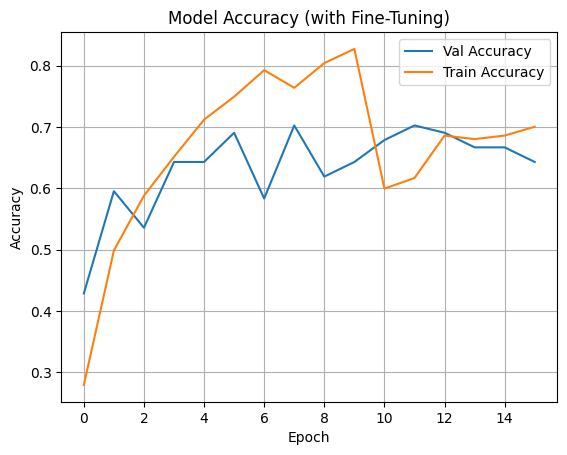

In [11]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Final Validation Accuracy: {val_acc * 100:.2f}%")
print(f"📉 Final Validation Loss: {val_loss:.4f}")

# Accuracy Plot
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy (with Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


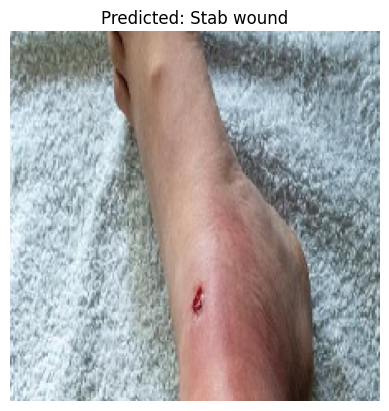

In [37]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_labels = list(train_gen.class_indices.keys())

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.show()

# Use uploaded image filename here
predict_image("/content/drive/MyDrive/Wound Detection/Wound_dataset/Stab wound/stab_wound (9).jpg")
